In [1]:
import sys, os
sys.path.append('src')
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from utils import temporal_sort

In [2]:
# Deafening
z2_raw = loadmat('data_from_Fabiola/zscore_deafening.mat')
z_predeaf, z_postdeaf = z2_raw['zscore_pre'][:,0], z2_raw['zscore_post'][:,0]

In [3]:
m, s = z_predeaf.mean(), z_predeaf.std()
z_predeaf = (z_predeaf - m) / s
z_postdeaf = (z_postdeaf - m) / s

In [4]:
# White Noise Perturbation
# z1_raw = loadmat('data_from_Fabiola/zscore_song.mat')
# z_correct, z_pert = z1_raw['zscore_song'], z1_raw['zscore_songwn'] # less data
z_correct = loadmat('data_from_Fabiola/mean_mat.mat')['mean_mat']
z_pert = loadmat('data_from_Fabiola/mean_mat2.mat')['mean_mat2']
t_pre, t0, t1 = 54, 62, 80
z_correct_t = z_correct - z_correct[:,t_pre:t0].mean(axis=1)[:,None]
z_pert_t = z_pert - z_pert[:,t_pre:t0].mean(axis=1)[:,None]
z_correct = z_correct_t[:,t0:t1].mean(axis=1)
z_pert = z_pert_t[:,t0:t1].mean(axis=1)

In [5]:
m, s = z_correct.mean(), z_correct.std()
z_correct = (z_correct - m) / s
z_pert = (z_pert - m) / s
z_correct_t = (z_correct_t - m) / s
z_pert_t = (z_pert_t - m) / s

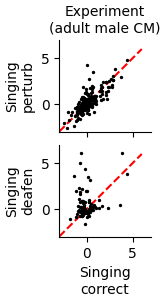

In [6]:
fig, ax = plt.subplots(2, figsize=(3, 3), sharex='all')
ax[0].scatter(z_correct, z_pert, s=8, c='k', zorder=-1)
ax[1].scatter(z_predeaf, z_postdeaf, s=8, c='k', zorder=-1)
for i, l in enumerate(['Singing\nperturb', 'Singing\ndeafen']):
    ax[i].plot([-3,6], [-3,6], c='r', ls='--', zorder=-2)
    ax[i].set(xlim=[-3,7], ylim=[-3,7], xticks=[0,5], yticks=[0,5], 
              ylabel=l)
    ax[i].set_rasterization_zorder(0)
    ax[i].axes.set_aspect('equal')
ax[0].set_title('Experiment\n(adult male CM)')
ax[-1].set(xlabel='Singing\ncorrect')
fig.savefig('svg/joint_dist_c_vs_nc_experiment.svg', bbox_inches='tight', dpi=300)

(283,)
2.4932459671951343e-16


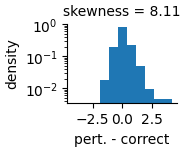

In [7]:
from scipy.stats import wilcoxon, skewtest
fig, ax = plt.subplots(1, figsize=(1.8, 1.5), sharex='all', sharey='all')
diff = z_pert - z_correct
print(diff.shape)
# pval = wilcoxon(diff, alternative='greater').pvalue
test = skewtest(diff, alternative='greater')
print(test.pvalue)
m = max(-diff.max(), diff.max())
ax.hist(diff, bins=11, range=(-m, m), density=True)
# ax.text(1, 1, '**', ha='center')
ax.set(xlabel='pert. - correct', ylabel='density', yscale='log', 
       title='skewness = %.2f' % test.statistic)
fig.savefig('svg/pert_diff_experiment.svg')

(88,)
1.413155639862499e-06


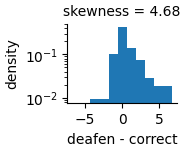

In [8]:
from scipy.stats import wilcoxon, skewtest
fig, ax = plt.subplots(1, figsize=(1.8, 1.5), sharex='all', sharey='all')
diff = z_postdeaf - z_predeaf
print(diff.shape)
test = skewtest(diff, alternative='greater')
print(test.pvalue)
m = max(-diff.max(), diff.max())
ax.hist(diff, bins=11, range=(-m, m), density=True)
# ax.text(2, 0.4, '**', ha='center')
ax.set(xlabel='deafen - correct', ylabel='density', yscale='log', 
       title='skewness = %.2f' % test.statistic)
fig.savefig('svg/deaf_diff_experiment.svg')

116 167


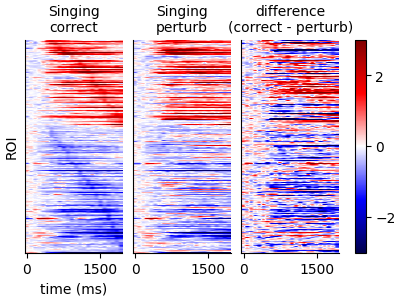

In [9]:
t_pre, t0, t1 = 6, 56, 80
# idx = temporal_sort(z_correct_t[:,t0:t1].T, by='rmax', t0=t_pre)[1]
idx = temporal_sort(z_correct_t[:,t0:t1].T, by='dmean', t0=t_pre)[1]
# tmax = np.argmax(np.abs(z_correct_t[idx,t0+t_pre:t1]), axis=1) + t_pre
fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(4,3))
norm = TwoSlopeNorm(0, -3, 3)
im = ax[0].imshow(z_correct_t[idx,t0:t1], cmap='seismic', norm=norm)
# ax[0].scatter(tmax-2, np.arange(len(idx)), marker='.', s=0.5, c='yellow', alpha=1)
ax[1].imshow(z_pert_t[idx,t0:t1], cmap='seismic', norm=norm)
ax[2].imshow(2*(z_correct_t[idx,t0:t1] - z_pert_t[idx,t0:t1]), cmap='seismic', norm=norm)
ax[0].set(yticks=[], xticks=[0, 18], xticklabels=[0, 1500], 
          xlabel='time (ms)', ylabel='ROI', title='Singing\ncorrect')
ax[1].set(title='Singing\nperturb')
ax[2].set(title='difference\n(correct - perturb)')
fig.colorbar(im, ax=ax, ticks=[-2, 0, 2])
fig.savefig('svg/supplementary/raster_experiment.svg', bbox_inches='tight', dpi=300)

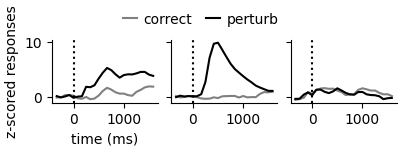

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(4, 1.5), sharex='all', sharey='all')

t0, t1 = 56, 80
dt = 1/12 * 1000
ts = (np.arange(t0, t1) - 60) * dt
idx = np.argsort(z_pert - z_correct)[[-2, -1, np.random.randint(0, len(z_pert))]]
for i, j in enumerate(idx):
    ax[i].plot(ts, z_correct_t[j,t0:t1], c='grey', label='correct' if i == 0 else '')
    ax[i].plot(ts, z_pert_t[j,t0:t1], c='k', label='perturb' if i == 0 else '')
    ax[i].axvline(0, ls=':', c='k')
ax[0].set(xlabel='time (ms)', ylabel='z-scored responses', title='\n')
fig.legend(ncols=2, loc='upper center')
fig.savefig('svg/example_exp_units.svg', bbox_inches='tight', dpi=300)